In [2]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk import tokenize
from collections import Counter
from spacy import displacy

pd.set_option('display.max_colwidth', 1200)
%matplotlib inline

## Approach 1

https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

In [4]:
df = pd.read_csv("C:/Users/wongzn/Desktop/df_dec.csv")

In [4]:
df.drop(['Article Link','Topics','Article Title'], axis=1, inplace = True)

In [5]:
sentences = []
count_sent = []
for i in range(len(df)):
    sentences.append([x for x in tokenize.sent_tokenize(df['Article Content'][i])])
    count_sent.append(len(tokenize.sent_tokenize(df['Article Content'][i])))

In [6]:
new =  [item for sublist in sentences for item in sublist]

In [7]:
df_sent = pd.concat([pd.Series(new)],axis=1)
df_sent.rename(columns={0:'Sent'},inplace=True)

In [14]:
df_sent.head()

,Sent
0,SINGAPORE - A 21-year-old Malaysian suspect was arrested at the junction of Shenton Way and Maxwell Road last Thursday (Aug 1) after he allegedly disposed of a plastic bag containing 336g of Ice at a carpark in the vicinity of Orchard Towers.
1,Officers from the Central Narcotics Bureau (CNB) had spotted him hopping onto his motorcycle in the carpark to make a hasty exit.
2,"They also recovered the plastic bag which contained 336g of Ice, valued at $33,000."
3,"This amount can feed the addiction of about 192 abusers for a week, the CNB said in a press release on Saturday."
4,"Three other suspected drug offenders, including a 30-year-old Singaporean man, were arrested at Orchard Towers and the International Building last Thursday."
5,"A total of $13,390 was also seized from the Singaporean and Malaysian suspects."
6,"The arrests were part of the CNB's latest islandwide anti-drug enforcement operation, which took place from July 22 to last Friday."
7,"Some 192 suspected drug offenders were arrested as part of the operation, which covered areas including Bedok, Bukit Merah, Choa Chu Kang, Hougang, Sembawang, Tampines, Telok Blangah and Yishun."
8,"According to the CNB, drugs worth more than $65,000 were seized during the blitz, including 499g of Ice, 99g of heroin, 113g of cannabis, 8g of ketamine, five Ecstasy tablets, 102g of new psychoactive substances and one bottle of methadone."
9,"SINGAPORE - When entering a pool of water, a person who does not know how to swim might not know to breathe in before entering, and to exhale slightly while submerged."


In [28]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]


In [33]:
get_entities("Three other suspected drug offenders, including a 30-year-old Singaporean man, were arrested at Orchard Towers and the International Building last Thursday")

['suspected drug offenders', 'Singaporean Orchard Towers']

In [36]:
entity_pairs = []

for i in tqdm(df_sent["Sent"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 65567/65567 [33:58<00:00, 32.17it/s]


In [37]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [41]:
relations = [get_relation(i) for i in tqdm(df_sent['Sent'])]
pd.Series(relations).value_counts()[:50]

100%|██████████| 65567/65567 [33:38<00:00, 32.48it/s] 


said              11812
added              2372
is                 2176
told               1214
was                1157
are                 828
noted               595
said in             565
have                563
said on             483
were                470
found               467
heard               411
jailed for          395
include             387
had                 356
be                  348
took                310
made                284
has                 244
expected            239
fined               238
received            234
asked               234
reported            207
advised             197
pleaded guilty      192
used                184
set                 179
announced           177
's                  174
showed              171
given               163
sentenced to        162
taken to            153
arrested            150
"                   149
included            146
started             145
seen                143
urged               142
understands     

In [42]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [43]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


In [51]:
pd.Series(relations).value_counts()[100:150]

confirmed       68
is in           67
became          67
shows           67
alerted         65
contacted       64
joined          64
taken           64
provide         63
tried           62
raised          62
said at         61
sent            60
went            60
sought          60
required        59
encouraged      59
says            59
hopes           59
began           58
visit           58
ordered         58
allow           57
charged in      57
stopped         56
seized          56
was in          56
held            56
came            56
involved        56
suggested       55
speaking at     55
do              55
failed          55
reminded        55
features        53
know            52
visited         52
come            52
explained       52
face            51
announced on    51
described       51
got             51
give            50
jailed          50
admitted to     49
arrested for    49
declined        49
allows          49
dtype: int64

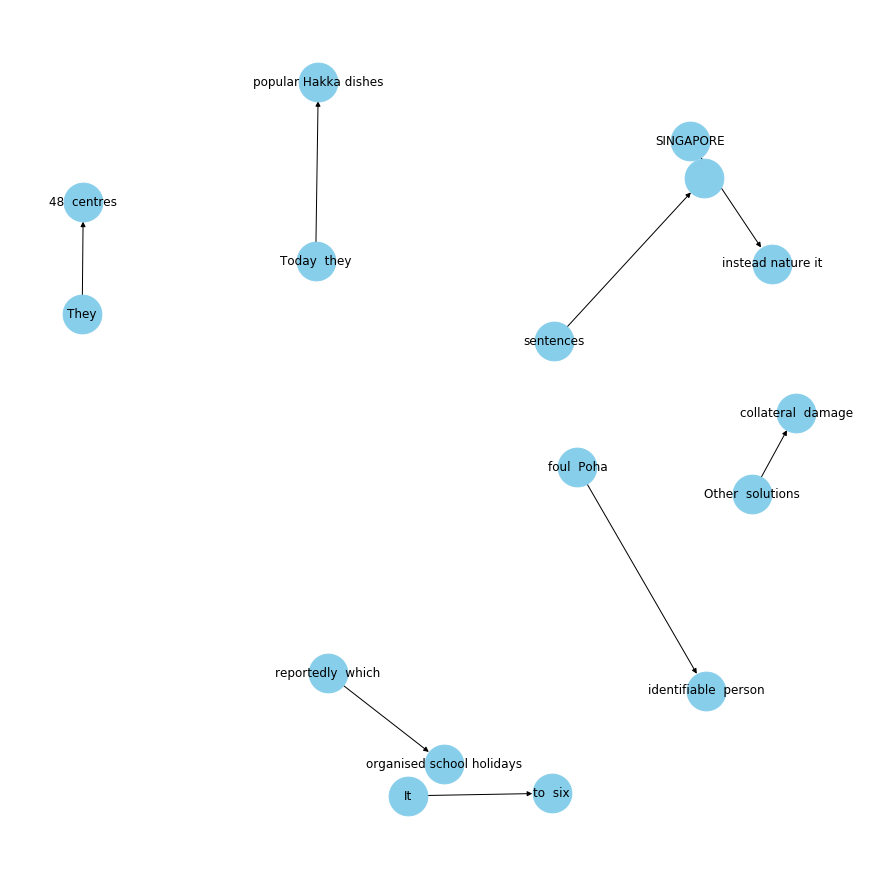

In [164]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="run"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Approach 2

In [55]:
import re 
import string 
import nltk 
import spacy 
import pandas as pd 
import numpy as np 
import math 
from tqdm import tqdm 

from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 

pd.set_option('display.max_colwidth', 200)

In [56]:
nlp = spacy.load("en_core_web_sm")

In [85]:
doc = df_sent['Sent'].apply(lambda x: nlp(x))

In [86]:
for tok in doc:
    print(tok.text," --> ",tok.dep_, " --> ", tok.pos_)

SINGAPORE  -->  compound  -->  PROPN
-  -->  punct  -->  PUNCT
A  -->  det  -->  DET
21-year  -->  npadvmod  -->  NUM
-  -->  punct  -->  PUNCT
old  -->  amod  -->  ADJ
Malaysian  -->  amod  -->  ADJ
suspect  -->  nsubjpass  -->  NOUN
was  -->  auxpass  -->  AUX
arrested  -->  ROOT  -->  VERB
at  -->  prep  -->  ADP
the  -->  det  -->  DET
junction  -->  pobj  -->  NOUN
of  -->  prep  -->  ADP
Shenton  -->  compound  -->  PROPN
Way  -->  pobj  -->  PROPN
and  -->  cc  -->  CCONJ
Maxwell  -->  compound  -->  PROPN
Road  -->  conj  -->  PROPN
last  -->  amod  -->  ADJ
Thursday  -->  npadvmod  -->  PROPN
(  -->  punct  -->  PUNCT
Aug  -->  parataxis  -->  PROPN
1  -->  nummod  -->  NUM
)  -->  punct  -->  PUNCT
after  -->  mark  -->  ADP
he  -->  nsubj  -->  PRON
allegedly  -->  advmod  -->  ADV
disposed  -->  advcl  -->  VERB
of  -->  prep  -->  ADP
a  -->  det  -->  DET
plastic  -->  amod  -->  ADJ
bag  -->  pobj  -->  NOUN
containing  -->  acl  -->  VERB
336  -->  nummod  -->  NUM
g  -

In [87]:
pattern = [{'POS':'NOUN'}, 
           {'LOWER': 'of'}, 
           {'LOWER': 'the'}, 
           {'POS': 'PROPN'}]

In [124]:
matcher = Matcher(nlp.vocab) 

#define the pattern 
pattern = [{'DEP':'amod', 'OP':"?"}, 
           {'POS':'NOUN'}, 
           {'LOWER': 'and', 'OP':"?"}, 
           {'LOWER': 'or', 'OP':"?"}, 
           {'POS': 'NOUN'}] 
           
matcher.add("matching_1", None, pattern) 

matches = matcher(doc[5]) 
span = doc[5][matches[0][1]:matches[0][2]] 
print(span.text)

IndexError: list index out of range

## Subtree Matching

In [129]:
displacy.render(doc[100], style='dep',jupyter=True)

In [130]:
def subtree_matcher(doc): 
  x = '' 
  y = '' 
  
  # iterate through all the tokens in the input sentence 
  for i,tok in enumerate(doc): 
    # extract subject 
    if tok.dep_.find("subjpass") == True: 
      y = tok.text 
      
    # extract object 
    if tok.dep_.endswith("obj") == True: 
      x = tok.text 
      
  return x,y

In [131]:
subtree_matcher(doc[0])


('Towers', 'suspect')

In [132]:
def subtree_matcher(doc):
  subjpass = 0

  for i,tok in enumerate(doc):
    # find dependency tag that contains the text "subjpass"    
    if tok.dep_.find("subjpass") == True:
      subjpass = 1

  x = ''
  y = ''

  # if subjpass == 1 then sentence is passive
  if subjpass == 1:
    for i,tok in enumerate(doc):
      if tok.dep_.find("subjpass") == True:
        y = tok.text

      if tok.dep_.endswith("obj") == True:
        x = tok.text
  
  # if subjpass == 0 then sentence is not passive
  else:
    for i,tok in enumerate(doc):
      if tok.dep_.endswith("subj") == True:
        x = tok.text

      if tok.dep_.endswith("obj") == True:
        y = tok.text

  return x,y

In [140]:
subtree_matcher(doc[7])

('Bedok', 'offenders')